In [1]:
# import dependencies
from __future__ import division 
import numpy as np
import pandas as pd
import gc
import pickle
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Merge, TimeDistributed, Lambda, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.preprocessing import sequence, text

from keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization, concatenate
from keras.models import Model

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# read the dataframe
df = pd.read_csv('quora_duplicate_questions.tsv', sep='\t')

In [3]:
# the data has 404290 rows and 6 columns
df.shape

(404290, 6)

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# count the positive and negative data
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [6]:
# drop unnecessary columns
df.drop(['id','qid1','qid2'], axis=1, inplace=True)

In [7]:
# function to clean text

def clean_text(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\/", " / ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " america ", text)
    text = re.sub(r"\0s", " 0 ", text)
    text = re.sub(r" 9 11 ", " 911 ", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r" j k ", " jk ", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

In [8]:
#Preprocess the data by cleaning the text
sents = []
for i in tqdm(range(len(df.question1))):
    sents.append(clean_text(df.question1[i]))
df['question1']  = sents

100%|██████████| 404290/404290 [00:48<00:00, 8342.66it/s] 


In [9]:
sents = []
for i in tqdm(range(len(df.question2))):
    sents.append(clean_text(df.question2[i]))
df['question2']  = sents

100%|██████████| 404290/404290 [01:00<00:00, 6636.49it/s]


In [10]:
df.head()

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh-i-noor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve it,find the remainder when math 23 ^ 24 / math is...,0
4,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water,0


In [11]:
#saving the cleaned data as a pickle file so that it can be reused
import pickle
with open ('question_pair.pickle', 'wb') as f:
    pickle.dump(df, f)

In [2]:
import pickle
with open('question_pair.pickle', 'rb') as f:
    df = pickle.load(f)

In [5]:
# count the number of words present per question
df['q1_count'] = [len(i.split()) for i in df.question1]
df['q2_count'] = [len(i.split()) for i in df.question2]

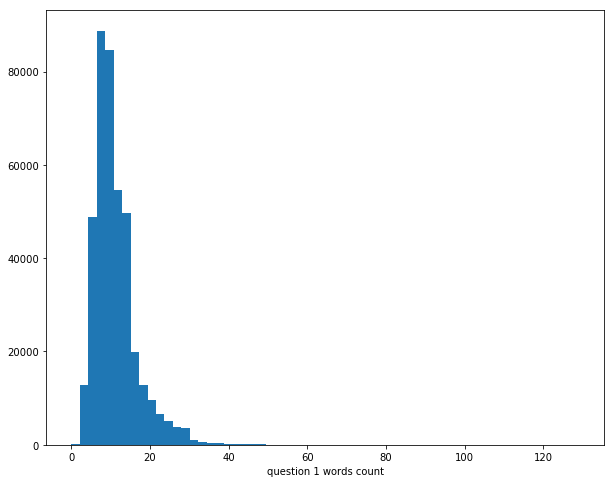

In [10]:
# visualize the number of words present so as to select the max length for the vectors
plt.figure(figsize=(10,8))
plt.hist(df['q1_count'], bins=60)
plt.xlabel('question 1 words count')
plt.show()

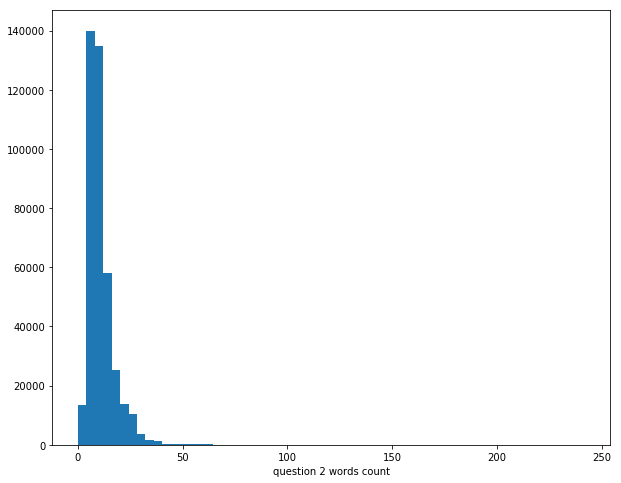

In [11]:
plt.figure(figsize=(10,8))
plt.hist(df['q2_count'], bins=60)
plt.xlabel('question 2 words count')
plt.show()

In [12]:
df.q1_count.max()

129

In [13]:
df.q2_count.max()

242

In [14]:
# considering the visualizations above max_len of 30 should be sufficient for the vectors

In [3]:
tk = text.Tokenizer(num_words=200000)
# we use keras Tokenizer to tokenizer the data. 
# we will only consider top 200000 words that occur in the dataset

max_len = 30
# the maximum length of each sequence

tk.fit_on_texts(list(df.question1.values.astype(str)) + list(df.question2.values.astype(str)))

#we now convert the text to numerical data
x1 = tk.texts_to_sequences(df.question1.values.astype(str))
x2 = tk.texts_to_sequences(df.question2.values.astype(str))

# we pad the sequences so that all questions are of the same length(30)
x1 = sequence.pad_sequences(x1, maxlen=max_len)
x2 = sequence.pad_sequences(x2, maxlen=max_len)


word_index = tk.word_index

In [4]:
#x1 and x2 denote the questions that were converted to sequences which can be fed to machine learning algorithms
print(x1.shape)
print(x2.shape)

(404290, 30)
(404290, 30)


In [5]:
# y is our target variable
y = df.is_duplicate.values

In [6]:
y.shape

(404290,)

In [7]:
#we split our data to train and test sets

from sklearn.model_selection import train_test_split

x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x1,x2,y, test_size = 0.1,random_state=2017)

In [31]:
# we create a dictionary of the words that have pretrained weights

embeddings_index = {}
f = open('glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [01:59, 18435.60it/s]

Found 2196016 word vectors.


In [32]:
# we now create a matrix of weights for the words present n our dataset


embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 88367/88367 [00:18<00:00, 4658.75it/s]


In [6]:
# free some ram
#embeddings_index = 0
df=0
x1=0
x2=0

gc.collect()

7

In [34]:
# sav the weight matrix for reuse
np.savetxt('embeddings.txt',embedding_matrix)

In [8]:
embedding_matrix = np.loadtxt('embeddings.txt')

In [12]:
embedding_matrix.shape

(88368, 300)

In [29]:
print('Base Model 1')
print('Build Model...')

ques1 = Input(shape=(30,))
ques2 = Input(shape=(30,))
q1 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques1)

q1 = TimeDistributed(Dense(300, activation='relu'))(q1)
q1 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(q1)


q2 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques2)

q2 = TimeDistributed(Dense(300, activation='relu'))(q2)
q2 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(q2)


merged = add([q1,q2])
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)
merged = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[ques1,ques2], outputs=merged)

checkpoint = ModelCheckpoint('base 1.h5', monitor='val_acc', save_best_only=True, verbose=2)

estop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Base Model 1
Build Model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 30, 300)       26510400    input_5[0][0]                    
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 30, 300)       26510400    input_6[0][0]                    
_______________________________________________________________

In [30]:
model.fit([x1_train, x2_train], y=y_train, batch_size=500, epochs=100,
verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,estop])

Train on 327474 samples, validate on 36387 samples
Epoch 1/100
327474/327474 [==============================] - 13s - loss: 0.5491 - acc: 0.7168 - val_loss: 0.5052 - val_acc: 0.7449
Epoch 2/100
327474/327474 [==============================] - 12s - loss: 0.4781 - acc: 0.7614 - val_loss: 0.4644 - val_acc: 0.7696
Epoch 3/100
327474/327474 [==============================] - 12s - loss: 0.4485 - acc: 0.7802 - val_loss: 0.4560 - val_acc: 0.7773
Epoch 4/100
327474/327474 [==============================] - 12s - loss: 0.4285 - acc: 0.7936 - val_loss: 0.4363 - val_acc: 0.7872
Epoch 5/100
327474/327474 [==============================] - 13s - loss: 0.4125 - acc: 0.8021 - val_loss: 0.4316 - val_acc: 0.7909
Epoch 6/100
327474/327474 [==============================] - 13s - loss: 0.3981 - acc: 0.8123 - val_loss: 0.4229 - val_acc: 0.7960
Epoch 7/100
327474/327474 [==============================] - 13s - loss: 0.3859 - acc: 0.8190 - val_loss: 0.4265 - val_acc: 0.7942
Epoch 8/100
327474/327474 [=====

In [35]:
# 81.5% validation accuracy
del q1
del q2
del merged
del model

K.clear_session()

gc.collect()

18048

In [24]:
print('Base Model 2')
print('Build Model...')

ques1 = Input(shape=(30,))
ques2 = Input(shape=(30,))
q1 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques1)

q1 = TimeDistributed(Dense(300, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(q1)


q2 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques2)

q2 = TimeDistributed(Dense(300, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(q2)


merged = add([q1,q2])
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.3)(merged)
merged = BatchNormalization()(merged)
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.3)(merged)
merged = BatchNormalization()(merged)
merged = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[ques1,ques2], outputs=merged)

checkpoint = ModelCheckpoint('base 2.h5', monitor='val_acc', save_best_only=True, verbose=2)

estop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Base Model 2
Build Model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 30, 300)       26510400    input_3[0][0]                    
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 30, 300)       26510400    input_4[0][0]                    
_______________________________________________________________

In [25]:
model.fit([x1_train, x2_train], y=y_train, batch_size=500, epochs=100,
verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,estop])

Train on 327474 samples, validate on 36387 samples
Epoch 1/100
327474/327474 [==============================] - 16s - loss: 0.5607 - acc: 0.7146 - val_loss: 0.5116 - val_acc: 0.7489
Epoch 2/100
327474/327474 [==============================] - 15s - loss: 0.4806 - acc: 0.7622 - val_loss: 0.4721 - val_acc: 0.7624
Epoch 3/100
327474/327474 [==============================] - 15s - loss: 0.4452 - acc: 0.7826 - val_loss: 0.4505 - val_acc: 0.7764
Epoch 4/100
327474/327474 [==============================] - 15s - loss: 0.4181 - acc: 0.7981 - val_loss: 0.4392 - val_acc: 0.7855
Epoch 5/100
327474/327474 [==============================] - 14s - loss: 0.3942 - acc: 0.8122 - val_loss: 0.5449 - val_acc: 0.7541
Epoch 6/100
327474/327474 [==============================] - 15s - loss: 0.3735 - acc: 0.8243 - val_loss: 0.4344 - val_acc: 0.7864
Epoch 7/100
327474/327474 [==============================] - 15s - loss: 0.3560 - acc: 0.8339 - val_loss: 0.4349 - val_acc: 0.7871
Epoch 8/100
327474/327474 [=====

In [26]:
# 80.2% accuracy
#Taking max in the lambda layer instead of sum and increasing the dropout seems to have made a bad efect.

del q1
del q2
del merged
del model
K.clear_session()

gc.collect()

0

In [14]:
print('Base Model 3')
print('Build Model...')

ques1 = Input(shape=(30,))
ques2 = Input(shape=(30,))
q1 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques1)

q1 = TimeDistributed(Dense(300, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(q1)


q2 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(ques2)

q2 = TimeDistributed(Dense(300, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(300,))(q2)


merged = add([q1,q2])
merged = BatchNormalization()(merged)
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(300, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[ques1,ques2], outputs=merged)

checkpoint = ModelCheckpoint('base 3.h5', monitor='val_acc', save_best_only=True, verbose=2)

estop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Base Model 3
Build Model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 30, 300)       26510400    input_3[0][0]                    
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 30, 300)       26510400    input_4[0][0]                    
_______________________________________________________________

In [15]:
model.fit([x1_train, x2_train], y=y_train, batch_size=500, epochs=100,
verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,estop])

Train on 327474 samples, validate on 36387 samples
Epoch 1/100
327474/327474 [==============================] - 16s - loss: 0.5029 - acc: 0.7476 - val_loss: 0.4351 - val_acc: 0.7862
Epoch 2/100
327474/327474 [==============================] - 15s - loss: 0.4159 - acc: 0.7992 - val_loss: 0.4110 - val_acc: 0.8008
Epoch 3/100
327474/327474 [==============================] - 15s - loss: 0.3754 - acc: 0.8233 - val_loss: 0.4031 - val_acc: 0.8077
Epoch 4/100
327474/327474 [==============================] - 15s - loss: 0.3432 - acc: 0.8423 - val_loss: 0.3949 - val_acc: 0.8139
Epoch 5/100
327474/327474 [==============================] - 15s - loss: 0.3160 - acc: 0.8570 - val_loss: 0.3981 - val_acc: 0.8181
Epoch 6/100
327474/327474 [==============================] - 14s - loss: 0.2918 - acc: 0.8692 - val_loss: 0.4020 - val_acc: 0.8178
Epoch 7/100
327474/327474 [==============================] - 14s - loss: 0.2713 - acc: 0.8797 - val_loss: 0.4063 - val_acc: 0.8178
Epoch 8/100
327474/327474 [=====

In [12]:
# 82.7% accuracy
#Taking max in the lambda layer instead of sum and decreasing the dropout works like a charm.

del q1
del q2
del merged
del model
K.clear_session()

gc.collect()

85

In [15]:
print('Base 4')

print("Build model . . ")

ques1 = Input(shape=(30,))
ques2 = Input(shape=(30,))
q1 = Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=30, trainable=False)(ques1)
q1 = Conv1D(filters = 64,kernel_size=2,strides = 1,padding='same', activation='relu')(q1)
q1 = Dropout(0.2)(q1)
q1 = GlobalAveragePooling1D()(q1)

q2 = Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=30, trainable=False)(ques2)
q2 = Conv1D(filters = 64,kernel_size=2,strides = 1,padding='same', activation='relu')(q2)
q2 = Dropout(0.2)(q2)
q2 = GlobalAveragePooling1D()(q2)


#merge1 = add([q1,q2])
#merge2 = subtract([q1,q2])
merged = concatenate([q1,q2])
merged = BatchNormalization()(merged)
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[ques1,ques2], outputs=merged)

checkpoint = ModelCheckpoint('base 4.h5', monitor='val_acc', save_best_only=True, verbose=2)

estop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Base 4
Build model . . 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 30, 300)       26510400    input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 30, 300)       26510400    input_2[0][0]                    
___________________________________________________________________

In [16]:
model.fit([x1_train, x2_train], y=y_train, batch_size=500, epochs=100,
verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,estop])

Train on 327474 samples, validate on 36387 samples
Epoch 1/100
327474/327474 [==============================] - 14s - loss: 0.5407 - acc: 0.7205 - val_loss: 0.4892 - val_acc: 0.7576
Epoch 2/100
327474/327474 [==============================] - 14s - loss: 0.4775 - acc: 0.7620 - val_loss: 0.4523 - val_acc: 0.7751
Epoch 3/100
327474/327474 [==============================] - 14s - loss: 0.4523 - acc: 0.7767 - val_loss: 0.4416 - val_acc: 0.7817
Epoch 4/100
327474/327474 [==============================] - 14s - loss: 0.4356 - acc: 0.7871 - val_loss: 0.4277 - val_acc: 0.7903
Epoch 5/100
327474/327474 [==============================] - 14s - loss: 0.4214 - acc: 0.7956 - val_loss: 0.4246 - val_acc: 0.7916
Epoch 6/100
327474/327474 [==============================] - 14s - loss: 0.4129 - acc: 0.8008 - val_loss: 0.4150 - val_acc: 0.7983
Epoch 7/100
327474/327474 [==============================] - 15s - loss: 0.4031 - acc: 0.8066 - val_loss: 0.4106 - val_acc: 0.8001
Epoch 8/100
327474/327474 [=====

In [15]:
#81.5% accuracy with a CNN model which is not a bad score.
K.clear_session()
del q1
del q2
del merged
del model

gc.collect()

0

In [17]:
print('Base 5')
print('Build Model . .')

question1 = Input(shape=(30,))
question2 = Input(shape=(30,))

q1 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(question1)
q1 = LSTM(30, return_sequences=True)(q1)

q2 = Embedding(len(word_index) + 1, 
                 300, 
                 weights=[embedding_matrix], 
                 input_length=30, 
                 trainable=False)(question2)
q2 = LSTM(30, return_sequences=True)(q2)


merged = add([q1,q2])
merged = Flatten()(merged)
merged = BatchNormalization()(merged)
merged = Dense(90, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(30, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = BatchNormalization()(merged)
merged = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=merged)

checkpoint = ModelCheckpoint('base 5.h5', monitor='val_acc', save_best_only=True, verbose=2)

estop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Base 5
Build Model . .
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 30, 300)       26510400    input_3[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 30, 300)       26510400    input_4[0][0]                    
____________________________________________________________________

In [18]:
model.fit([x1_train, x2_train], y=y_train, batch_size=1000, epochs=100,
verbose=1, validation_split=0.1, shuffle=True, callbacks=[checkpoint,estop])

Train on 327474 samples, validate on 36387 samples
Epoch 1/100
327474/327474 [==============================] - 40s - loss: 0.5666 - acc: 0.7009 - val_loss: 0.5244 - val_acc: 0.7369
Epoch 2/100
327474/327474 [==============================] - 45s - loss: 0.4898 - acc: 0.7573 - val_loss: 0.4826 - val_acc: 0.7565
Epoch 3/100
327474/327474 [==============================] - 48s - loss: 0.4532 - acc: 0.7791 - val_loss: 0.4549 - val_acc: 0.7774
Epoch 4/100
327474/327474 [==============================] - 49s - loss: 0.4267 - acc: 0.7950 - val_loss: 0.4431 - val_acc: 0.7851
Epoch 5/100
327474/327474 [==============================] - 50s - loss: 0.4048 - acc: 0.8080 - val_loss: 0.4360 - val_acc: 0.7894
Epoch 6/100
327474/327474 [==============================] - 50s - loss: 0.3875 - acc: 0.8182 - val_loss: 0.4386 - val_acc: 0.7911
Epoch 7/100
327474/327474 [==============================] - 54s - loss: 0.3705 - acc: 0.8279 - val_loss: 0.4300 - val_acc: 0.7942
Epoch 8/100
327474/327474 [=====